In [29]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [19]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [20]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [23]:
#Check columns for first rows of each class
col = session.query(Station).first()
col.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20fcb784280>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [24]:
#Check columns for first rows of each class
col = session.query(Measurement).first()
col.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20fcb784760>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'date': '2010-01-01'}

In [25]:
# Calculate the date 1 year ago from the last data point in the database
get_last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = get_last_date.date
print(dt.date.fromisoformat(str(last_date)))

year_before = dt.date.fromisoformat(last_date) - dt.timedelta(days=365)
print(year_before)


2017-08-23
2016-08-23


In [27]:
# Perform a query to retrieve the data and precipitation scores
data_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_before).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_prcp_df = pd.DataFrame(data_prcp)
data_prcp_df['date'] = pd.to_datetime(data_prcp_df['date'])
data_prcp_df.dtypes
data_prcp_df = data_prcp_df.set_index('date')

#Rename prcp to precipitation
data_prcp_df = data_prcp_df.rename(columns={"prcp": "precipitation"})

# Sort the dataframe by date
data_prcp_sorted = data_prcp_df.groupby(['date']).sum()
data_prcp_sorted.head()


,precipitation
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


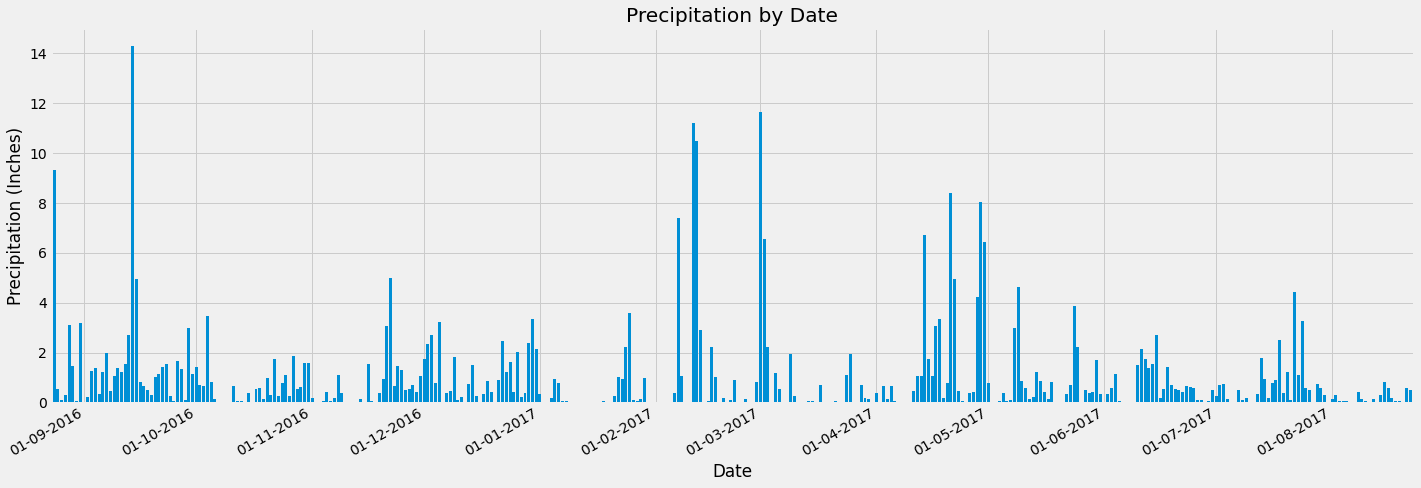

In [28]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates
#fig
fig, ax = plt.subplots(figsize=(20,7))
# for formats
ax.bar(data_prcp_sorted.index.values, data_prcp_sorted['precipitation'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

# labels
plt.title("Precipitation by Date")
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")

# limits
plt.xlim(dt.date.fromisoformat(str(year_before)), dt.date.fromisoformat(str(last_date)))

plt.tight_layout()

plt.savefig("images/precip_by_date.png")
plt.show()

In [36]:
# Use Pandas to calcualte the summary statistics for the precipitation data

stats_df = pd.DataFrame({"Mean": data_prcp_sorted['precipitation'].mean(),
                                 "Median": data_prcp_sorted['precipitation'].median(),
                                 "Variance": data_prcp_sorted['precipitation'].var(),
                                 "Standard Deviation": data_prcp_sorted['precipitation'].std(),
                                 "SEM": data_prcp_sorted['precipitation'].sem()},
                                index=[f"{year_before} to {last_date}"])
stats_df

,Mean,Median,Variance,Standard Deviation,SEM
2016-08-23 to 2017-08-23,0.978907,0.405,3.155417,1.776349,0.092851


In [37]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [38]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(
    func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [40]:
# Choose the station with the highest number of temperature observations.
station = "USC00519281"
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observe = pd.DataFrame(session.query(Measurement.tobs).filter(Measurement.station == station).filter(
    Measurement.date >= year_before).all())

observe.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'session' is not defined

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
